# This is a visualization of usage over time fo the Toronto Bike data available through Open Data from the City of Toronto

## Historical data can be found: https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/

In [8]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt

path = os.getcwd()+'/bikeshare-ridership-2021'

col_names = ["Trip_Id", 
              "Trip_Duration", 
              "Start_Station_Id", 
              "Start_Time", 
              "Start_Station_Name", 
              "End_Station_Id", 
              "End_Time",
              "End_Station_Name", 
              "Bike_Id",
              "User_Type"
             ]
#get filenames from directory for bikeshare data and sor by month
files = sorted(glob.glob(os.path.join(path, "*.csv")))
print(files)

#read in all files in the directory
#Use column names defined above to avoid issues of bad charaters
l = [pd.read_csv(filename, header = 0, names = col_names, encoding="ISO-8859-1") for filename in files]
#Concatenate into one dataframe, ignoring index because it is meaningless
d = pd.concat(l, axis=0, ignore_index=True)


display(d)


['/Users/sophiemcgibbon/Coding_projects/TorontoBike/bikeshare-ridership-2021/Bike share ridership 2021-01.csv', '/Users/sophiemcgibbon/Coding_projects/TorontoBike/bikeshare-ridership-2021/Bike share ridership 2021-02.csv', '/Users/sophiemcgibbon/Coding_projects/TorontoBike/bikeshare-ridership-2021/Bike share ridership 2021-03.csv', '/Users/sophiemcgibbon/Coding_projects/TorontoBike/bikeshare-ridership-2021/Bike share ridership 2021-04.csv', '/Users/sophiemcgibbon/Coding_projects/TorontoBike/bikeshare-ridership-2021/Bike share ridership 2021-05.csv', '/Users/sophiemcgibbon/Coding_projects/TorontoBike/bikeshare-ridership-2021/Bike share ridership 2021-06.csv', '/Users/sophiemcgibbon/Coding_projects/TorontoBike/bikeshare-ridership-2021/Bike share ridership 2021-07.csv', '/Users/sophiemcgibbon/Coding_projects/TorontoBike/bikeshare-ridership-2021/Bike share ridership 2021-08.csv', '/Users/sophiemcgibbon/Coding_projects/TorontoBike/bikeshare-ridership-2021/Bike share ridership 2021-09.csv', 

,Trip_Id,Trip_Duration,Start_Station_Id,Start_Time,Start_Station_Name,End_Station_Id,End_Time,End_Station_Name,Bike_Id,User_Type
0,10644218,1315,7021,01/01/2021 00:04,Bay St / Albert St,7164.0,01/01/2021 00:26,Gould St / Yonge St (Ryerson University),6795.0,Annual Member
1,10644220,396,7534,01/01/2021 00:07,Walnut Ave / Queen St W,7524.0,01/01/2021 00:13,Lisgar Park,4176.0,Casual Member
2,10644221,86,7162,01/01/2021 00:10,Hayter St / Laplante Ave,7006.0,01/01/2021 00:11,Bay St / College St (East Side),1814.0,Annual Member
3,10644222,741,7003,01/01/2021 00:10,Madison Ave / Bloor St W,7272.0,01/01/2021 00:22,Yonge St / Dundonald St - SMART,198.0,Casual Member
4,10644223,2073,7562,01/01/2021 00:11,Priscilla Ave / Dundas St W - SMART,7562.0,01/01/2021 00:45,Priscilla Ave / Dundas St W - SMART,6688.0,Casual Member
...,...,...,...,...,...,...,...,...,...,...
3575177,14805103,372,7065,12/31/2021 23:56,Dundas St E / Parliament St,7472.0,01/01/2022 00:02,Dundas St E / Victoria St,3487.0,Casual Member
3575178,14805104,762,7233,12/31/2021 23:56,King / Cowan Ave - SMART,7569.0,01/01/2022 00:08,Toronto Inukshuk Park,4195.0,Annual Member
3575179,14805105,355,7065,12/31/2021 23:56,Dundas St E / Parliament St,7472.0,01/01/2022 00:02,Dundas St E / Victoria St,4574.0,Casual Member
3575180,14805107,770,7292,12/31/2021 23:56,Granby St / Church St - SMART,7076.0,01/01/2022 00:09,York St / Queens Quay W,5879.0,Annual Member


In [10]:
#Convert to datetime
import datetime as dt
d[['Start_Time','End_Time']] = d[['Start_Time','End_Time']].apply(pd.to_datetime, format = "%m/%d/%Y %H:%M")
display(d)

,Trip_Id,Trip_Duration,Start_Station_Id,Start_Time,Start_Station_Name,End_Station_Id,End_Time,End_Station_Name,Bike_Id,User_Type
0,10644218,1315,7021,2021-01-01 00:04:00,Bay St / Albert St,7164.0,2021-01-01 00:26:00,Gould St / Yonge St (Ryerson University),6795.0,Annual Member
1,10644220,396,7534,2021-01-01 00:07:00,Walnut Ave / Queen St W,7524.0,2021-01-01 00:13:00,Lisgar Park,4176.0,Casual Member
2,10644221,86,7162,2021-01-01 00:10:00,Hayter St / Laplante Ave,7006.0,2021-01-01 00:11:00,Bay St / College St (East Side),1814.0,Annual Member
3,10644222,741,7003,2021-01-01 00:10:00,Madison Ave / Bloor St W,7272.0,2021-01-01 00:22:00,Yonge St / Dundonald St - SMART,198.0,Casual Member
4,10644223,2073,7562,2021-01-01 00:11:00,Priscilla Ave / Dundas St W - SMART,7562.0,2021-01-01 00:45:00,Priscilla Ave / Dundas St W - SMART,6688.0,Casual Member
...,...,...,...,...,...,...,...,...,...,...
3575177,14805103,372,7065,2021-12-31 23:56:00,Dundas St E / Parliament St,7472.0,2022-01-01 00:02:00,Dundas St E / Victoria St,3487.0,Casual Member
3575178,14805104,762,7233,2021-12-31 23:56:00,King / Cowan Ave - SMART,7569.0,2022-01-01 00:08:00,Toronto Inukshuk Park,4195.0,Annual Member
3575179,14805105,355,7065,2021-12-31 23:56:00,Dundas St E / Parliament St,7472.0,2022-01-01 00:02:00,Dundas St E / Victoria St,4574.0,Casual Member
3575180,14805107,770,7292,2021-12-31 23:56:00,Granby St / Church St - SMART,7076.0,2022-01-01 00:09:00,York St / Queens Quay W,5879.0,Annual Member


## Check data then clean

### Check DateTime worked properly, if data is behaving as expected

In [11]:
#Data seems to be increasing, check if it is
print("Is the data increasing?")
print(d['Start_Time'].is_monotonic_increasing)

Is the data increasing?
False


#### It is not... Let's check data is as expected by matching duration to start and end time. Make sure that the date time worked properly (there may be differences in formatting)

In [12]:
import numpy as np
print("How many recorded durations DO NOT match the duration calculated with start and end times?")
#Find where trip duration is more than 60 seconds off from the calculated duration
#Sum results of where funtion (0 if the times match, 1 if they do not)
print(sum(np.where((abs(d["Trip_Duration"]-((d["End_Time"]-d["Start_Time"]).dt.total_seconds())) <= 60),0, 1)))


How many recorded durations DO NOT match the duration calculated with start and end times?
58


### Clean things up

#### A small fraction of the durations do not match start and end times. Let's remove them

In [13]:
d = d[(abs(d["Trip_Duration"]-((d["End_Time"]-d["Start_Time"]).dt.total_seconds())) <= 60)]
display(d)

,Trip_Id,Trip_Duration,Start_Station_Id,Start_Time,Start_Station_Name,End_Station_Id,End_Time,End_Station_Name,Bike_Id,User_Type
0,10644218,1315,7021,2021-01-01 00:04:00,Bay St / Albert St,7164.0,2021-01-01 00:26:00,Gould St / Yonge St (Ryerson University),6795.0,Annual Member
1,10644220,396,7534,2021-01-01 00:07:00,Walnut Ave / Queen St W,7524.0,2021-01-01 00:13:00,Lisgar Park,4176.0,Casual Member
2,10644221,86,7162,2021-01-01 00:10:00,Hayter St / Laplante Ave,7006.0,2021-01-01 00:11:00,Bay St / College St (East Side),1814.0,Annual Member
3,10644222,741,7003,2021-01-01 00:10:00,Madison Ave / Bloor St W,7272.0,2021-01-01 00:22:00,Yonge St / Dundonald St - SMART,198.0,Casual Member
4,10644223,2073,7562,2021-01-01 00:11:00,Priscilla Ave / Dundas St W - SMART,7562.0,2021-01-01 00:45:00,Priscilla Ave / Dundas St W - SMART,6688.0,Casual Member
...,...,...,...,...,...,...,...,...,...,...
3575177,14805103,372,7065,2021-12-31 23:56:00,Dundas St E / Parliament St,7472.0,2022-01-01 00:02:00,Dundas St E / Victoria St,3487.0,Casual Member
3575178,14805104,762,7233,2021-12-31 23:56:00,King / Cowan Ave - SMART,7569.0,2022-01-01 00:08:00,Toronto Inukshuk Park,4195.0,Annual Member
3575179,14805105,355,7065,2021-12-31 23:56:00,Dundas St E / Parliament St,7472.0,2022-01-01 00:02:00,Dundas St E / Victoria St,4574.0,Casual Member
3575180,14805107,770,7292,2021-12-31 23:56:00,Granby St / Church St - SMART,7076.0,2022-01-01 00:09:00,York St / Queens Quay W,5879.0,Annual Member


#### Let's assume aything shorter than two minutes is not and actual 'use' of the bike, and that we want day trips/commutes -- not trips longer than 6 hours. We could use interquartile range to identify outliers but because we have a good intuition about wht the data 'should' look like, we can simply slice it.

In [14]:
#take only data longer than a minute and shorter than a day
N_trips_raw = d.shape[0]#find number of trips
print("Number of trips shorter than 2 minutes: ",(d["Trip_Duration"]< 2*60).sum(), 
      "\tPercent of total: ", ((d["Trip_Duration"]< 60).sum())/N_trips_raw)
print("Number of trips longer than 6 hours: ",(d["Trip_Duration"] > 60*60*6).sum(), 
      "\tPercent of total: ", ((d["Trip_Duration"]> 60*60*24).sum())/N_trips_raw)

#Retain only trips within the specified duration range (does not make copy)
d = d[d["Trip_Duration"].between(60*2, 60*60*6)]
N_trips = d.shape[0]#find new number of trips
print("Origional trip number: ", N_trips_raw, "\nNumber of trips longer than 2 minutes and shorter than 6 hours: ", N_trips,
     "\nPercent of trips retained: ", (N_trips)/N_trips_raw*100 )

Number of trips shorter than a minute:  46669 	Percent of total:  0.0031548556078054915
Number of trips longer than 6 hours:  3401 	Percent of total:  0.0001661480832552941
Origional trip number:  3575124 
Number of trips longer than one minute and shorter than 6 hours:  3525054 
Percent of trips retained:  98.59948913660058


#### Define simple numerical data histogram plotting function to help clean data

In [15]:
def HistPlot(data, text_size, ylabel, xlabel, title, xticks, xrot, **kwargs):
    fig, ax = plt.subplots()
    data.plot(**kwargs, fontsize = text_size, ax = ax)
    ax.set_xlabel(xlabel, size = text_size)
    ax.set_ylabel(ylabel, size = text_size)
    ax.set_title(title, size = text_size+2)
    if xticks != False:
        ax.set_xticklabels(xticks)
    plt.xticks(rotation=xrot)

    return()


Plot a histograms of trip duration, and number of trips per weekday and month to get a sense of the data

()

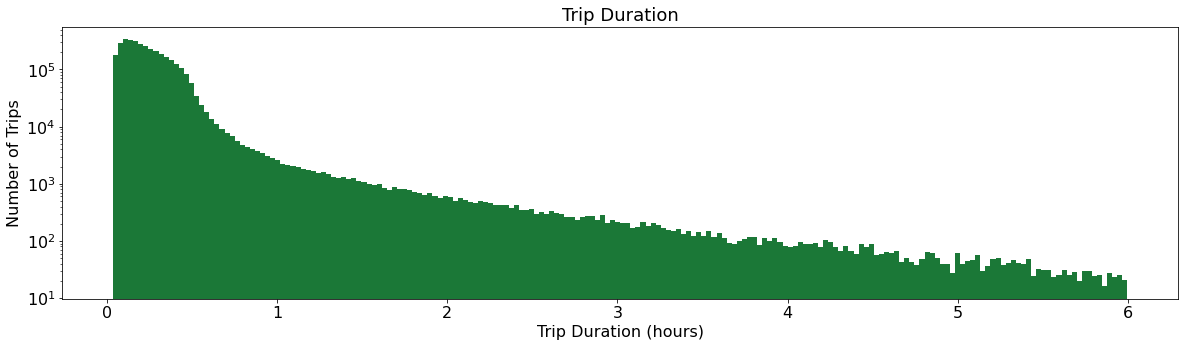

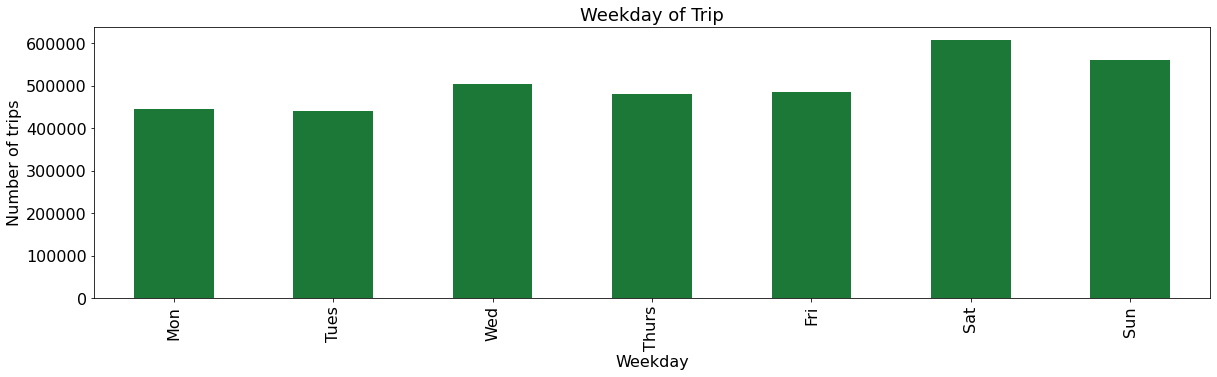

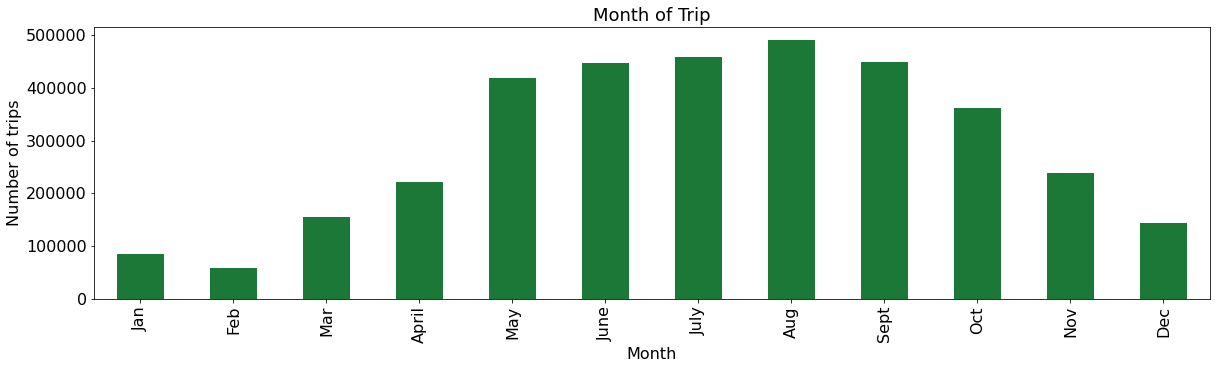

In [16]:
#Plot duration histrogram (maybe someone stole a bike....)
HistPlot(d['Trip_Duration']/(3600), 16, "Number of Trips", "Trip Duration (hours)","Trip Duration", False, 0, kind = "hist", bins = 200, color = "#1b7837", figsize = (20,5), logy = True)

#Plot start time
df = d.groupby(d["Start_Time"].dt.weekday).size().reset_index()
df.columns = ["Weekday", 'count']
xticks = ["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"]
HistPlot(df, 16, "Number of trips", "Weekday", "Weekday of Trip",xticks, 90, kind = "bar", x="Weekday", y = "count", color = "#1b7837", figsize = (20,5), legend = False)

#Plot start time
df = d.groupby(d["Start_Time"].dt.month).size().reset_index()
df.columns = ["Month", 'count']
xticks = ["Jan", "Feb", "Mar","April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
HistPlot(df, 16, "Number of trips", "Month", "Month of Trip",xticks, 90, kind = "bar", x="Month", y = "count", color = "#1b7837", figsize = (20,5), legend = False)


#### This all looks as expected.

Double check that the times are all the same timezone. Data files are by month, so an easy way is to plot the start time of trips per month and see if there are obvious discrepancies.

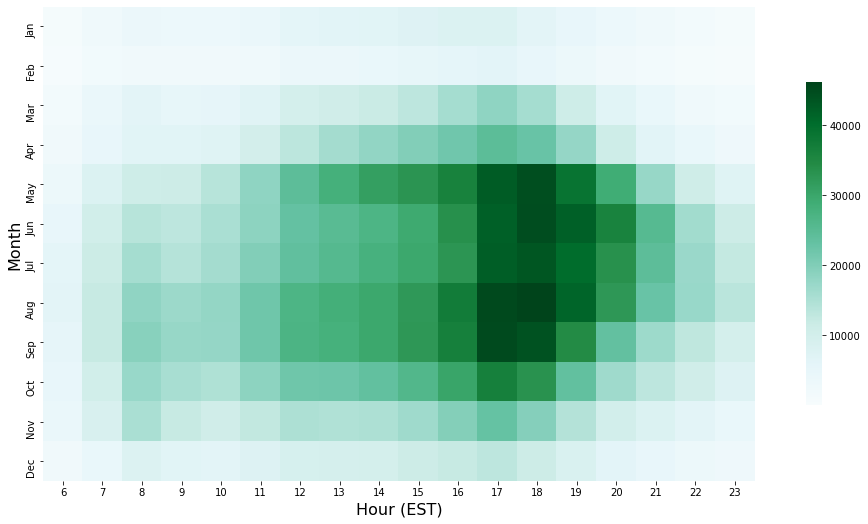

In [9]:
import seaborn as sns
df_heat = d.groupby( [ d["Start_Time"].dt.hour, d["Start_Time"].dt.month]).size()#.reset_index(name='count')
df_heat.index.rename(['Hour', 'Month'], inplace = True)
df_heat.reset_index(name='count')
piv = pd.pivot_table(df_heat.reset_index(name='count'), values="count",index=["Hour"], columns=["Month"], fill_value=0).transpose()

Month = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

plt.figure(figsize=(15, 7))
ax = sns.heatmap(piv, cmap = 'BuGn', cbar = True, yticklabels = Month, square=True, cbar_kws={"shrink": 0.68})
plt.tight_layout()
plt.xlim(6, 24)
ax.set_xlabel('Hour (EST)', fontsize=16)
ax.set_ylabel('Month', fontsize=16)

plt.show()

()

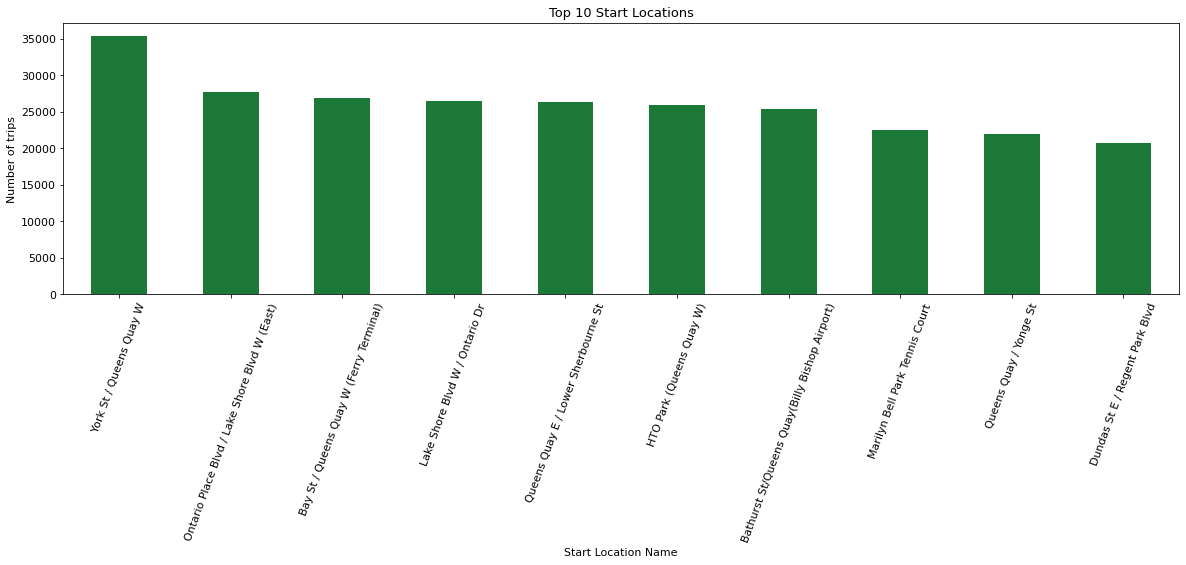

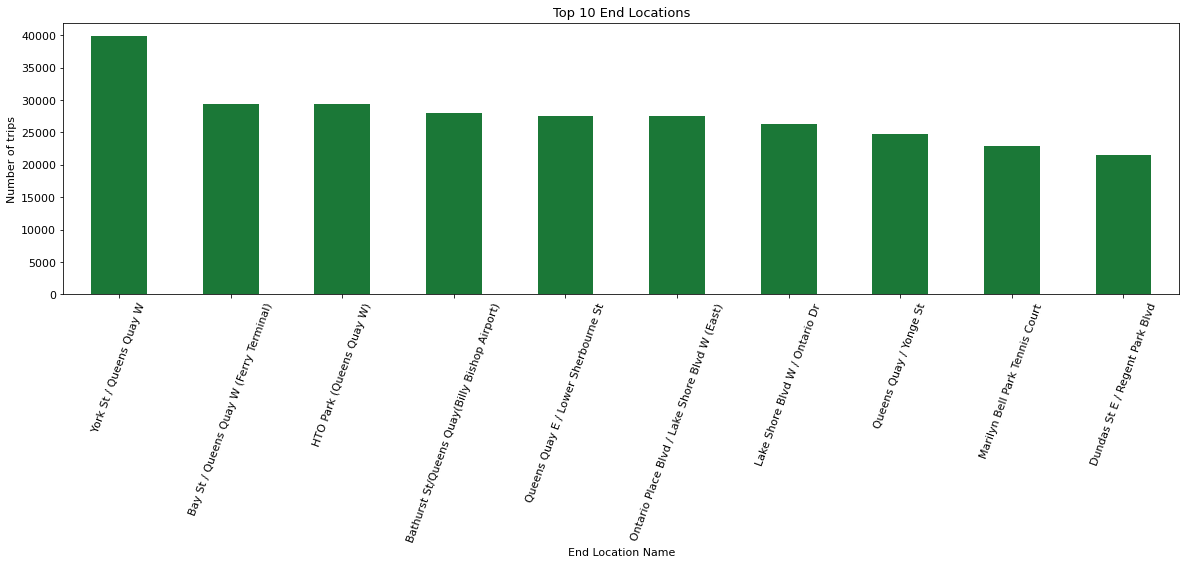

In [17]:

#Plot trip start location
df = d.groupby(["Start_Station_Name"]).size().to_frame().sort_values([0], ascending = False).head(10).reset_index()
df.columns = ["Start_Station_Name", 'count']
HistPlot(df, 11, "Number of trips", "Start Location Name", "Top 10 Start Locations",False, 70, kind = "bar", x="Start_Station_Name", y = "count", color = "#1b7837", figsize = (20,5), legend = False)

#Plot trip end location
df = d.groupby(["End_Station_Name"]).size().to_frame().sort_values([0], ascending = False).head(10).reset_index()
df.columns = ["End_Station_Name", 'count']
HistPlot(df, 11, "Number of trips", "End Location Name","Top 10 End Locations", False, 70, kind = "bar", x="End_Station_Name", y = "count", color = "#1b7837", figsize = (20,5), legend = False)


## We expect the nuber of rides to correlate well with good weather. Let's check

In [18]:
df_weath = pd.read_csv("en_climate_daily_ON_6158355_2021_P1D.csv", skipinitialspace=True)
print("\nWeather dataframe columns\n",list(df_weath.columns), "\n")

df_weath["Day of Year"] = pd.to_datetime(df_weath['Date/Time'], format = "%Y-%m-%d").dt.dayofyear
d["Day of Year"] = d["Start_Time"].dt.dayofyear

#add temperature informaiton to dataframe with map from statcan weather data
d['Mean Temp (°C)'] = d["Day of Year"].map(df_weath.set_index("Day of Year")['Mean Temp (°C)'])

#Some data is missing, drop these rows
d = d[d['Mean Temp (°C)'].notna()]

#Use dictionary of temperature data to add mean temp column to grouped data based on count
temp_dict = df_weath['Mean Temp (°C)'].to_dict()
df = d.groupby(d["Start_Time"].dt.dayofyear).size().reset_index()
df.columns = ['Start_Time', 'count']
df['Mean Temp (°C)'] = df.index.map(temp_dict)
df = df[df['Mean Temp (°C)'].notna()]
print("Summary of ridership data by day\n",df.describe())


Weather dataframe columns
 ['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Date/Time', 'Year', 'Month', 'Day', 'Data Quality', 'Max Temp (°C)', 'Max Temp Flag', 'Min Temp (°C)', 'Min Temp Flag', 'Mean Temp (°C)', 'Mean Temp Flag', 'Heat Deg Days (°C)', 'Heat Deg Days Flag', 'Cool Deg Days (°C)', 'Cool Deg Days Flag', 'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag', 'Total Precip (mm)', 'Total Precip Flag', 'Snow on Grnd (cm)', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)', 'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)', 'Spd of Max Gust Flag'] 

Summary of ridership data by day
        Start_Time         count  Mean Temp (°C)
count  359.000000    359.000000      359.000000
mean   181.440111   9624.735376       10.895822
std    105.465746   6000.217942        9.928659
min      1.000000    698.000000      -10.800000
25%     90.500000   4014.000000        2.550000
50%    180.000000   9241.000000       10.500000
75%    271.500000  14204.000

### Using sklearn to find a linear relationship between temperature and rides

(359, 1) (359,)


Text(0, 0.5, 'Number of riders')

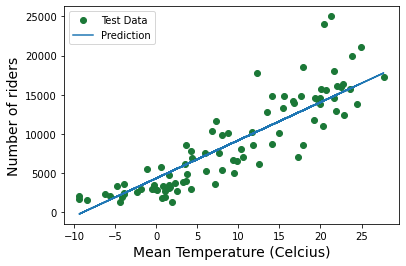

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

def Linear_Model(feature_cols, df):

    feature_cols = ['Mean Temp (°C)']
    X = df.loc[:, feature_cols]
    y = df.loc[:, "count"]
    print(X.shape, y.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True)
    #instantiate model
    logreg = LinearRegression()
    #fit 
    logreg.fit(X_train, y_train)
    #predict
    y_pred = logreg.predict(X_test)
    return(X_test, y_test, y_pred)

X_test, y_test, y_pred = Linear_Model(['Mean Temp (°C)'], df)
plt.plot(X_test["Mean Temp (°C)"], y_test, 'o', color = "#1b7837", label = "Test Data")
plt.plot(X_test["Mean Temp (°C)"], y_pred, label = "Prediction")
plt.legend()
plt.xlabel("Mean Temperature (Celcius)", size = 14)
plt.ylabel("Number of riders", size = 14)

### What about casual users vs. annual members? Are there differences in the relationshsip between ridership and weather?

Summary of Casual ridership data by day
        Start_Time       count  Mean Temp (°C)
count  359.000000  359.000000      359.000000
mean   181.440111    0.002742       10.895822
std    105.465746    0.002375        9.928659
min      1.000000    0.000021      -10.800000
25%     90.500000    0.000647        2.550000
50%    180.000000    0.002423       10.500000
75%    271.500000    0.003904       19.700000
max    365.000000    0.011233       28.600000
Summary of Annual ridership data by day
        Start_Time       count  Mean Temp (°C)
count  359.000000  359.000000      359.000000
mean   181.440111    0.002761       10.895822
std    105.465746    0.001592        9.928659
min      1.000000    0.000289      -10.800000
25%     90.500000    0.001311        2.550000
50%    180.000000    0.002441       10.500000
75%    271.500000    0.004397       19.700000
max    365.000000    0.006171       28.600000
Number of Casual Rides:  1400568 ,	Number of Annual Rides:  2094886
other:  0
(359, 1) (35

Text(0, 0.5, 'Number of riders')

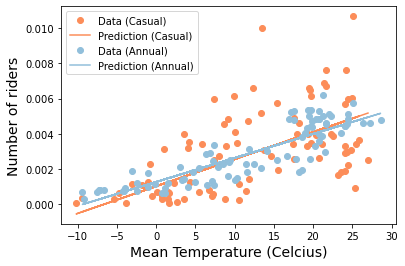

In [20]:
#Make Casualand Annual membership dataframes

#Use dictionary of temperature data to add mean temp column to grouped data based on count
c = d.loc[d["User_Type"] == "Casual Member"]
dfc = d.groupby(c["Start_Time"].dt.dayofyear).size().reset_index()
dfc.columns = ['Start_Time', 'count']
dfc['Mean Temp (°C)'] = dfc.index.map(temp_dict)
dfc['count'] = dfc['count']/sum(dfc['count'])
dfc = dfc[dfc['Mean Temp (°C)'].notna()]
print("Summary of Casual ridership data by day\n",dfc.describe())

a = d.loc[d["User_Type"] == "Annual Member"]
dfa = d.groupby(a["Start_Time"].dt.dayofyear).size().reset_index()
dfa.columns = ['Start_Time', 'count']
dfa['count'] = dfa['count']/sum(dfa['count'])
dfa['Mean Temp (°C)'] = dfa.index.map(temp_dict)
dfa = dfa[dfa['Mean Temp (°C)'].notna()]
print("Summary of Annual ridership data by day\n",dfa.describe())
print('Number of Casual Rides: ', c.shape[0],",\tNumber of Annual Rides: ", a.shape[0])
print('other: ', d.shape[0]-c.shape[0]-a.shape[0])

#Casual Users
X_test_c, y_test_c, y_pred_c = Linear_Model(['Mean Temp (°C)'], dfc)
#Annual Users
X_test_a, y_test_a, y_pred_a = Linear_Model(['Mean Temp (°C)'], dfa)
#other


plt.plot(X_test_c["Mean Temp (°C)"], y_test_c, 'o', color = "#fc8d59", label = "Data (Casual)")
plt.plot(X_test_c["Mean Temp (°C)"], y_pred_c, color = "#fc8d59", label = "Prediction (Casual)")
#plt.plot(X_test["Mean Temp (°C)"], y_test/sum(df['count']), 'o', color = "#1b7837", label = "Test Data")
plt.plot(X_test_a["Mean Temp (°C)"], y_test_a, 'o', color = "#91bfdb", label = "Data (Annual)")
plt.plot(X_test_a["Mean Temp (°C)"], y_pred_a, color = "#91bfdb", label = "Prediction (Annual)")
#plt.plot(X_test["Mean Temp (°C)"], y_pred/sum(df['count']), label = "Prediction (All)")
plt.legend()
plt.xlabel("Mean Temperature (Celcius)", size = 14)
plt.ylabel("Number of riders", size = 14)


In [21]:
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(dfc['count'], dfa['count'])
print(fvalue, pvalue)

0.01569168169459527 0.900347780122759


We can reject the hypothesis that temperature affects casual and annual users differently. Let's use a decision tree to identify what the most important features are for number of riders.

## How often do peope ride alone (two bikes taken at same station with same end station and trip duration)